In [2]:
attr_path = "/content/drive/MyDrive/ML PROJECT/lfw_attributes.txt"
data_path = "/content/drive/MyDrive/ML PROJECT/lfw-deepfunneled.tgz"

In [3]:

#importing tensorflow modules

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt


In [4]:
import os


In [5]:

import pandas as pd
from copy import deepcopy
from tqdm import tqdm

In [6]:
import tarfile

In [7]:
def load_data(dx=80,dy=80, dimx=45,dimy=45):
  attribs = pd.read_csv(attr_path, sep='\t', skiprows=1)
  attribs = pd.DataFrame(attribs.iloc[:, :-1].values, columns=attribs.columns[1:])
  attr_img = set(map(tuple, attribs[["person", "imagenum"]].values))
  # Read photos
  img_data = []
  pids = []
  with tarfile.open(data_path) as f:
    for mem in tqdm(f.getmembers()):
      if mem.isfile() and mem.name.endswith(".jpg"):

        img = cv2.imdecode(np.asarray(bytearray(f.extractfile(mem).read()), dtype=np.uint8), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[dy:-dy, dx:-dx]
        img = cv2.resize(img, (dimx, dimy))

        fname = os.path.split(mem.name)[-1]
        fname_splitted = fname[:-4].replace('_', ' ').split()
        pid = ' '.join(fname_splitted[:-1])
        pnum = int(fname_splitted[-1])
        if (pid, pnum) in attr_img:
          img_data.append(img)
          pids.append({'person': pid, 'imagenum': pnum})

  pids = pd.DataFrame(pids)
  img_data = np.stack(img_data).astype('uint8')

  all_attrs = pids.merge(attribs, on=('person','imagenum')).drop(["imagenum"], axis=1)

  return img_data, all_attrs

In [8]:
imgX, attributes = load_data()


100%|██████████| 13233/13233 [00:15<00:00, 876.28it/s]


In [9]:
imgX = np.array(imgX / 255.0, dtype='float32')

In [10]:
#45,45
height = imgX.shape[1]
width = imgX.shape[2]

In [11]:

imgXtrain, imgXval = train_test_split(imgX, test_size=0.2, random_state=42)

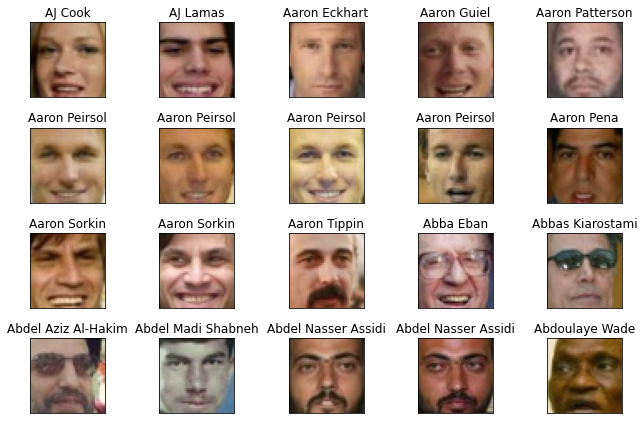

In [ ]:
plt.figure(figsize=(9,6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(imgX[i])
    plt.title(attributes["person"][i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# del imgX
# import gc
# gc.collect()

In [12]:
def generate_occluded(sample):
  sample2 = deepcopy(sample)
  sample2[:,(width//2)+1 :, :] = 0
  return sample2
# generate_occluded(imgXtrain[:2])

def retrieve_first_half(sample,occ):

  sample[:(width//2)+1, :] = occ[:(width//2)+1, :]



# ENCODER-DECODER Without Any Convolutional Layers

In [13]:
IMG_SHAPE = imgXtrain.shape[1:]

In [ ]:
basic_code_size = 32

In [17]:
def enc_dec_basic_model(IMG_SHAPE,basic_code_size):
  basic_enc = tf.keras.Sequential()
  #input layer
  basic_enc.add(tf.keras.layers.InputLayer(input_shape=IMG_SHAPE))
  #flatten the image
  basic_enc.add(tf.keras.layers.Flatten())
  #fully connected layer                  
  basic_enc.add(tf.keras.layers.Dense(basic_code_size))

  ip = tf.keras.layers.Input(IMG_SHAPE)
  encoder_op = basic_enc(ip)

  basic_dec= tf.keras.Sequential()
  basic_dec.add(tf.keras.layers.InputLayer(input_shape=(basic_code_size,)))
  basic_dec.add(tf.keras.layers.Dense(np.prod(IMG_SHAPE)))  
  #create image shape
  basic_dec.add(tf.keras.layers.Reshape(IMG_SHAPE))

  recreate_image = basic_dec(encoder_op)

  return ip,recreate_image



In [14]:
drive_path = "/content/drive/MyDrive/ML PROJECT"

In [ ]:
# del basic_enc2,basic_dec2,encoder_op,recreate_image,basic_model2
# import gc
# gc.collect()

In [ ]:
ip,recreate_image = enc_dec_basic_model(IMG_SHAPE,32)
basic_model = M.Model(ip,recreate_image)
basic_model.compile(optimizer='adam', loss='mse')

In [ ]:
hist1 = basic_model.fit(x=imgXtrain,y=imgXtrain, epochs=15,validation_data=(imgXval,imgXval))

Epoch 1/15
329/329 [==============================] - 4s 4ms/step - loss: 0.0249 - val_loss: 0.0118
Epoch 2/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 3/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 4/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 5/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 6/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 7/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 8/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 9/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 10/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0059

In [ ]:
basic_model.evaluate(imgXval,imgXval)

83/83 [==============================] - 0s 2ms/step - loss: 0.0056


0.005590398795902729

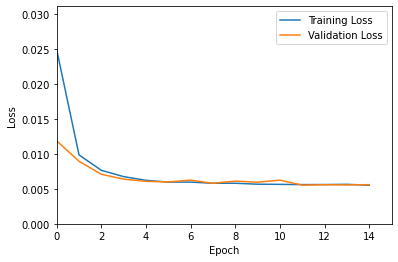

In [ ]:

epochs_range = range(15)
val_loss = hist1.history['val_loss']
tr_loss = hist1.history['loss']
plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, (1+0.25)*max(max(tr_loss),max(val_loss))])
plt.xlim([0, 15])

plt.legend(loc='upper right')

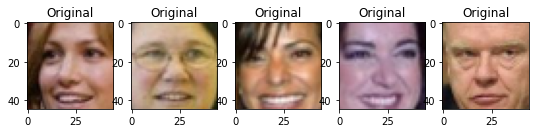

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.title("Original")
  plt.imshow(np.clip(imgXval[i],0,1))
plt.show()

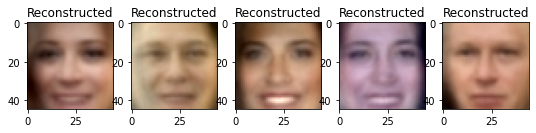

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  enc_op = basic_enc.predict(imgXval[i][None])[0]
  dec_op = basic_dec.predict(enc_op[None])[0]
  
  plt.subplot(2,5,i+1)
  plt.title("Reconstructed")
  plt.imshow(np.clip(dec_op,0,1))
plt.show()

In [18]:
# occXtest = generate_occluded(imgXtest)

ip_64,recreate_image_64 = enc_dec_basic_model(IMG_SHAPE,64)
occ_basic_model_64 = M.Model(ip_64,recreate_image_64)
occ_basic_model_64.compile(optimizer='adam', loss='mse')

In [ ]:

tr_loss=[]
vl_loss=[]

In [20]:

for i in range(10):
  print("epoch : {}".format(i+1))
  occXtrain = generate_occluded(imgXtrain)
  occXval = generate_occluded(imgXval)
  l = occ_basic_model_64.fit(x=occXtrain,y=imgXtrain, epochs=1,validation_data=(occXval,imgXval))
  tr_loss.append(l.history["loss"])
  vl_loss.append(l.history["val_loss"])


epoch : 1
329/329 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0080
epoch : 2
329/329 [==============================] - 2s 5ms/step - loss: 0.0079 - val_loss: 0.0080
epoch : 3
329/329 [==============================] - 2s 5ms/step - loss: 0.0078 - val_loss: 0.0080
epoch : 4
329/329 [==============================] - 2s 5ms/step - loss: 0.0078 - val_loss: 0.0078
epoch : 5
329/329 [==============================] - 2s 5ms/step - loss: 0.0078 - val_loss: 0.0078
epoch : 6
329/329 [==============================] - 2s 5ms/step - loss: 0.0078 - val_loss: 0.0079
epoch : 7
329/329 [==============================] - 2s 5ms/step - loss: 0.0077 - val_loss: 0.0077
epoch : 8
329/329 [==============================] - 2s 5ms/step - loss: 0.0077 - val_loss: 0.0077
epoch : 9
329/329 [==============================] - 2s 5ms/step - loss: 0.0076 - val_loss: 0.0078
epoch : 10
329/329 [==============================] - 2s 5ms/step - loss: 0.0076 - val_loss: 0.0078


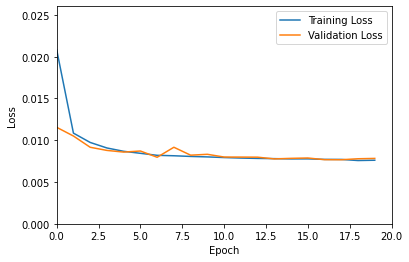

In [21]:

epochs_range = range(20)

plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, vl_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.25 * max(max(tr_loss),max(vl_loss))[0] ])
plt.xlim([0, 20])

plt.legend(loc='upper right')

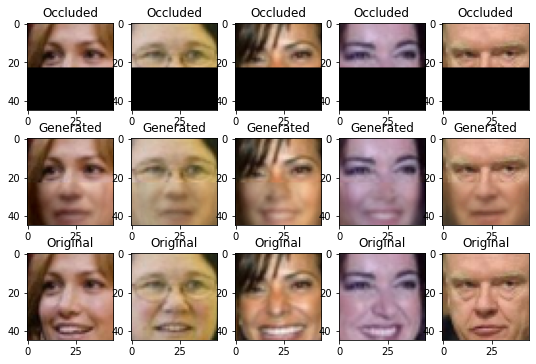

In [22]:


plt.figure(figsize=(9,6))
for i in range(5):
  oenc_op2 = occ_basic_model_64.layers[1].predict(occXval[i][None])[0]
  odec_op2 = occ_basic_model_64.layers[2].predict(oenc_op2[None])[0]
  retrieve_first_half(odec_op2,occXval[i])
  plt.subplot(3,5,i+1)
  plt.title("Occluded")
  plt.imshow(np.clip(occXval[i],0,1))
  plt.subplot(3,5,i+6)
  plt.title("Generated")
  plt.imshow(np.clip(odec_op2,0,1))
  plt.subplot(3,5,i+11)
  plt.title("Original")
  plt.imshow(np.clip(imgXval[i],0,1))
plt.show()

In [30]:
occ_basic_model_64.evaluate(occXval,imgXval)

83/83 [==============================] - 0s 3ms/step - loss: 0.0078


0.007826910354197025

In [36]:
occ_basic_model_64.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 45, 45, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 64)                388864    
_________________________________________________________________
sequential_1 (Sequential)    (None, 45, 45, 3)         394875    
Total params: 783,739
Trainable params: 783,739
Non-trainable params: 0
_________________________________________________________________


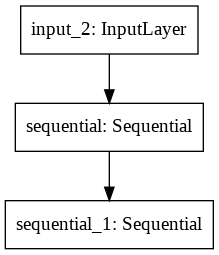

In [44]:
tf.keras.utils.plot_model(occ_basic_model_64)


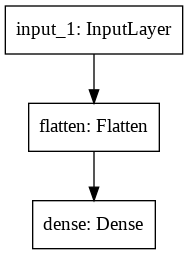

In [42]:
tf.keras.utils.plot_model(occ_basic_model_64.layers[1])


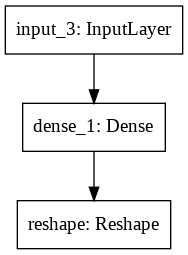

In [43]:
tf.keras.utils.plot_model(occ_basic_model_64.layers[2])


## Developing deep CNN based Model

In [23]:
def deep_cnn_model(img_shape, latent_dim):


    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.layers.InputLayer(img_shape))
    encoder.add(tf.keras.layers.Conv2D(32, input_shape=img_shape, kernel_size=(5, 5), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    encoder.add(tf.keras.layers.Conv2D(64, input_shape=img_shape[1:], kernel_size=(5, 5), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    encoder.add(
        tf.keras.layers.Conv2D(128, input_shape=img_shape[1:], kernel_size=(5, 5), activation='elu', padding='same'))

    encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    encoder.add(
        tf.keras.layers.Conv2D(256, input_shape=img_shape[1:], kernel_size=(5, 5), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(tf.keras.layers.Flatten())
    encoder.add(tf.keras.layers.Dense(latent_dim))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(L.InputLayer((latent_dim,)))
    decoder.add(L.Dense(np.prod(img_shape)))
    decoder.add(L.Reshape(img_shape))

    decoder.add(L.Conv2DTranspose(128, input_shape=img_shape, kernel_size=(5, 5), activation='elu', padding='same'))

    decoder.add(L.Conv2DTranspose(64, input_shape=img_shape, kernel_size=(5, 5), activation='elu', padding='same'))

    decoder.add(L.Conv2DTranspose(32, input_shape=img_shape, kernel_size=(5, 5), activation='elu', padding='same'))

    decoder.add(L.Conv2DTranspose(3, input_shape=img_shape, kernel_size=(5, 5), activation=None, padding='same'))

    return encoder, decoder

In [ ]:
del deep_model_32,cnn_encoder_32,cnn_decoder_32

In [ ]:
cnn_encoder_32, cnn_decoder_32 = deep_cnn_model(IMG_SHAPE, latent_dim=32)

In [ ]:

inp_32 = tf.keras.layers.Input(IMG_SHAPE)
enc_op_32 = cnn_encoder_32(inp_32)
dec_op_32 = cnn_decoder_32(enc_op_32)

deep_model_32 = tf.keras.models.Model(inp_32,dec_op_32)
deep_model_32.compile(optimizer="adamax", loss='mse')


In [ ]:
hist_32 = deep_model_32.fit(x=imgXtrain,y=imgXtrain, epochs=15,validation_data=(imgXval,imgXval))

Epoch 1/15
329/329 [==============================] - 24s 70ms/step - loss: 0.0210 - val_loss: 0.0108
Epoch 2/15
329/329 [==============================] - 22s 66ms/step - loss: 0.0092 - val_loss: 0.0079
Epoch 3/15
329/329 [==============================] - 22s 66ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 4/15
329/329 [==============================] - 22s 65ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 5/15
329/329 [==============================] - 22s 66ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 6/15
329/329 [==============================] - 22s 66ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 7/15
329/329 [==============================] - 22s 66ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 8/15
329/329 [==============================] - 21s 65ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 9/15
329/329 [==============================] - 21s 65ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 10/15
329/329 [==============================] - 21s 65ms/step - loss: 0.005

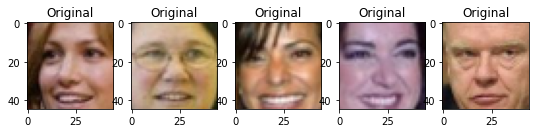

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.title("Original")
  plt.imshow(np.clip(imgXval[i],0,1))
plt.show()

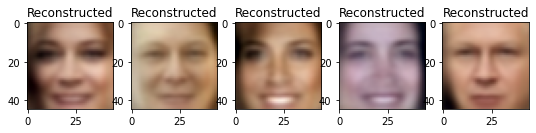

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  enc_op1 = cnn_encoder_32.predict(imgXval[i][None])[0]
  dec_op1 = cnn_decoder_32.predict(enc_op1[None])[0]
  
  plt.subplot(1,5,i+1)
  plt.title("Reconstructed")
  plt.imshow(np.clip(dec_op1,0,1))
plt.show()

In [ ]:
tf.keras.models.save_model(deep_model_32,drive_path+"/sv_deep_model_32")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML PROJECT/sv_deep_model_32/assets


In [24]:
load_32 = tf.keras.models.load_model(drive_path+"/sv_deep_model_32")

In [ ]:
reconstruction_mse = load_32.evaluate(imgXval, imgXval, verbose=0)
reconstruction_mse

0.005318338517099619

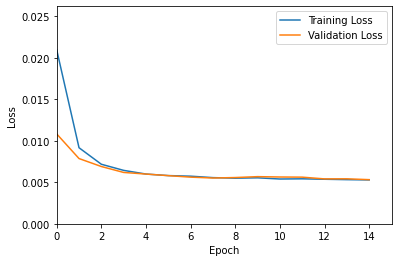

In [ ]:

epochs_range = range(15)
val_loss = hist_32.history['val_loss']
tr_loss = hist_32.history['loss']
plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, (1+0.25)*max(max(tr_loss),max(val_loss))])
plt.xlim([0, 15])

plt.legend(loc='upper right')

# OCCLUSION STARTS

In [ ]:
del occ_cnn_encoder_64,occ_cnn_decoder_64,occ_deep_model_64

In [ ]:
tf.keras.backend.clear_session()
occ_cnn_encoder_64, occ_cnn_decoder_64 = deep_cnn_model(IMG_SHAPE, latent_dim=512)

inp_64 = tf.keras.layers.Input(IMG_SHAPE)
occ_enc_op_64 = occ_cnn_encoder_64(inp_64)
occ_dec_op_64 = occ_cnn_decoder_64(occ_enc_op_64)

occ_deep_model_64 = tf.keras.models.Model(inp_64,occ_dec_op_64)
occ_deep_model_64.compile(optimizer="adam", loss='mse')

In [ ]:

for i in range(25):
  occXtrain = generate_occluded(imgXtrain)
  occXval = generate_occluded(imgXval)
  occ_deep_model_64.fit(x=occXtrain,y=imgXtrain, epochs=1,validation_data=(occXval,imgXval))

329/329 [==============================] - 22s 66ms/step - loss: 0.0051 - val_loss: 0.0075


In [ ]:
tf.keras.models.save_model(occ_deep_model_64,drive_path+"/occ_deep_model_512")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML PROJECT/occ_deep_model_512/assets


In [ ]:
occ_deep_model_64.evaluate(occXval,imgXval)

83/83 [==============================] - 2s 22ms/step - loss: 0.0075


0.007501304615288973

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'sequential')>

In [27]:
occ_deep_model_512 = tf.keras.models.load_model(drive_path+"/occ_deep_model_512")

In [ ]:
# plt.figure(figsize=(9,6))
# for i in range(5)
#   plt.subplot(2,5,i+1)
#   plt.title("Occluded")
#   plt.imshow(np.clip(occXval[i],0,1))

# plt.show()

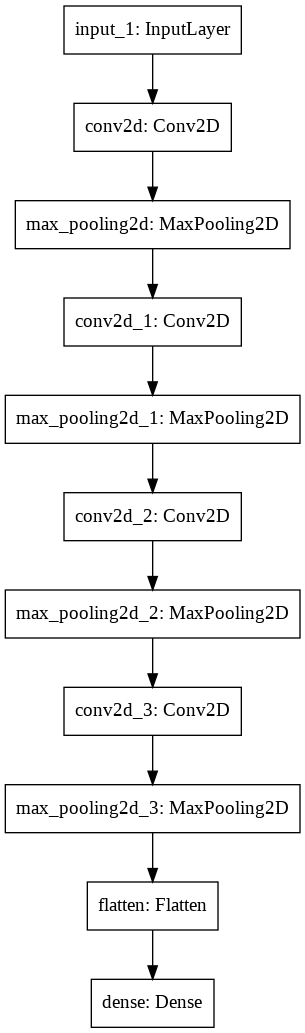

In [41]:
tf.keras.utils.plot_model(occ_deep_model_512.layers[1])

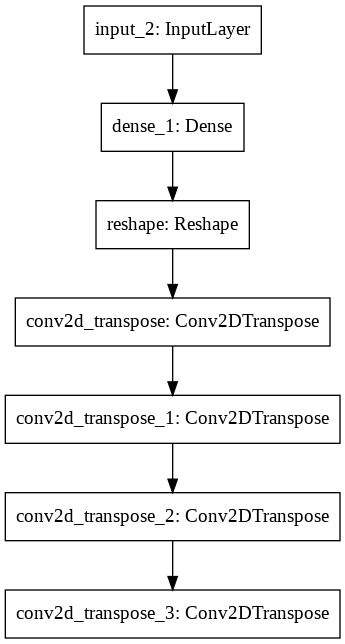

In [40]:
tf.keras.utils.plot_model(occ_deep_model_512.layers[2])

In [28]:
occ_deep_model_512.layers

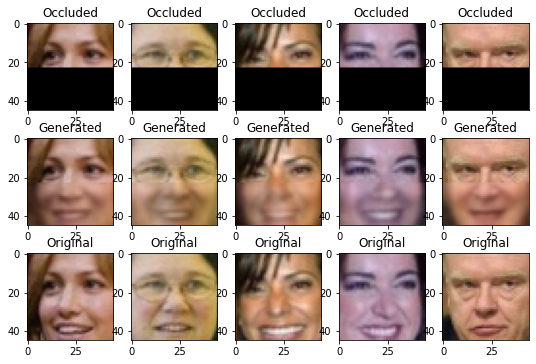

In [29]:
plt.figure(figsize=(9,6))
for i in range(5):
  oenc_op2 = occ_deep_model_512.layers[1].predict(occXval[i][None])[0]
  odec_op2 = occ_deep_model_512.layers[2].predict(oenc_op2[None])[0]
  retrieve_first_half(odec_op2,occXval[i])
  plt.subplot(3,5,i+1)
  plt.title("Occluded")
  plt.imshow(np.clip(occXval[i],0,1))
  plt.subplot(3,5,i+6)
  plt.title("Generated")
  plt.imshow(np.clip(odec_op2,0,1))
  plt.subplot(3,5,i+11)
  plt.title("Original")
  plt.imshow(np.clip(imgXval[i],0,1))
plt.show()

CHANGE lATENT DIMS

In [ ]:
tf.keras.backend.clear_session()
occ_cnn_encoder_128, occ_cnn_decoder_128 = deep_cnn_model(IMG_SHAPE, latent_dim=128)

inp_128 = tf.keras.layers.Input(IMG_SHAPE)
occ_enc_op_128 = occ_cnn_encoder_128(inp_128)
occ_dec_op_128 = occ_cnn_decoder_128(occ_enc_op_128)

occ_deep_model_128 = tf.keras.models.Model(inp_128,occ_dec_op_128)
occ_deep_model_128.compile(optimizer="adam", loss='mse')

In [ ]:

for i in range(20):
  print("epoch : {}".format(i+1))
  occXtrain = generate_occluded(imgXtrain)
  occXval = generate_occluded(imgXval)
  occ_deep_model_128.fit(x=occXtrain,y=imgXtrain, epochs=1,validation_data=(occXval,imgXval))

epoch : 1
329/329 [==============================] - 43s 39ms/step - loss: 0.0217 - val_loss: 0.0115
epoch : 2
329/329 [==============================] - 12s 37ms/step - loss: 0.0102 - val_loss: 0.0091
epoch : 3
329/329 [==============================] - 12s 37ms/step - loss: 0.0089 - val_loss: 0.0102
epoch : 4
329/329 [==============================] - 12s 37ms/step - loss: 0.0083 - val_loss: 0.0084
epoch : 5
329/329 [==============================] - 12s 37ms/step - loss: 0.0078 - val_loss: 0.0081
epoch : 6
329/329 [==============================] - 12s 37ms/step - loss: 0.0076 - val_loss: 0.0079
epoch : 7
329/329 [==============================] - 12s 37ms/step - loss: 0.0071 - val_loss: 0.0076
epoch : 8
329/329 [==============================] - 12s 37ms/step - loss: 0.0070 - val_loss: 0.0077
epoch : 9
329/329 [==============================] - 12s 37ms/step - loss: 0.0068 - val_loss: 0.0080
epoch : 10
329/329 [==============================] - 12s 37ms/step - loss: 0.0065 - val_lo

In [ ]:
tf.keras.models.save_model(occ_deep_model_128,drive_path+"/occ_deep_model_128")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML PROJECT/occ_deep_model_128/assets


In [33]:
occ_deep_model_128 = tf.keras.models.load_model(drive_path+"/occ_deep_model_128")

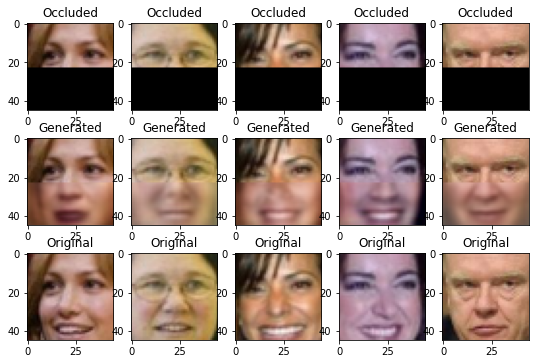

In [32]:
plt.figure(figsize=(9,6))
for i in range(5):
  oenc_op2 = occ_deep_model_128.layers[1].predict(occXval[i][None])[0]
  odec_op2 = occ_deep_model_128.layers[2].predict(oenc_op2[None])[0]
  retrieve_first_half(odec_op2,occXval[i])
  plt.subplot(3,5,i+1)
  plt.title("Occluded")
  plt.imshow(np.clip(occXval[i],0,1))
  plt.subplot(3,5,i+6)
  plt.title("Generated")
  plt.imshow(np.clip(odec_op2,0,1))
  plt.subplot(3,5,i+11)
  plt.title("Original")
  plt.imshow(np.clip(imgXval[i],0,1))
plt.show()

In [ ]:
occ_deep_model_128.evaluate(occXval,imgXval)

83/83 [==============================] - 1s 13ms/step - loss: 0.0076


0.007584051229059696

#Latent = 64

In [ ]:
tf.keras.backend.clear_session()
occ_cnn_encoder0_64, occ_cnn_decoder0_64 = deep_cnn_model(IMG_SHAPE, latent_dim=64)

inp0_64 = tf.keras.layers.Input(IMG_SHAPE)
occ_enc_op0_64 = occ_cnn_encoder0_64(inp0_64)
occ_dec_op0_64 = occ_cnn_decoder0_64(occ_enc_op0_64)

occ_deep_model0_64 = tf.keras.models.Model(inp0_64,occ_dec_op0_64)
occ_deep_model0_64.compile(optimizer="adam", loss='mse')

In [ ]:

for i in range(20):
  print("epoch : {}".format(i+1))
  occXtrain = generate_occluded(imgXtrain)
  occXval = generate_occluded(imgXval)
  occ_deep_model0_64.fit(x=occXtrain,y=imgXtrain, epochs=1,validation_data=(occXval,imgXval))

epoch : 1
329/329 [==============================] - 13s 38ms/step - loss: 0.0390 - val_loss: 0.0144
epoch : 2
329/329 [==============================] - 12s 37ms/step - loss: 0.0130 - val_loss: 0.0114
epoch : 3
329/329 [==============================] - 12s 37ms/step - loss: 0.0111 - val_loss: 0.0110
epoch : 4
329/329 [==============================] - 12s 37ms/step - loss: 0.0101 - val_loss: 0.0103
epoch : 5
329/329 [==============================] - 12s 37ms/step - loss: 0.0096 - val_loss: 0.0093
epoch : 6
329/329 [==============================] - 12s 38ms/step - loss: 0.0091 - val_loss: 0.0089
epoch : 7
329/329 [==============================] - 12s 38ms/step - loss: 0.0087 - val_loss: 0.0091
epoch : 8
329/329 [==============================] - 12s 38ms/step - loss: 0.0083 - val_loss: 0.0083
epoch : 9
329/329 [==============================] - 12s 37ms/step - loss: 0.0080 - val_loss: 0.0082
epoch : 10
329/329 [==============================] - 12s 37ms/step - loss: 0.0076 - val_lo

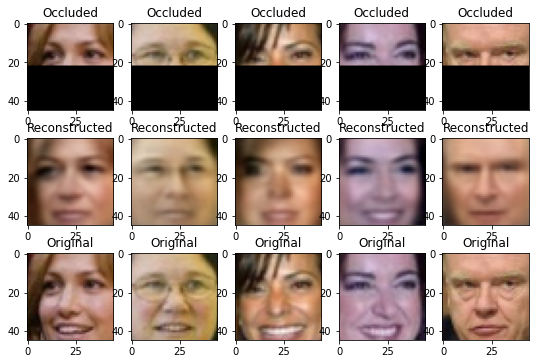

In [ ]:
tf.keras.models.save_model(occ_deep_model0_64,drive_path+"/occ_deep_model_64")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML PROJECT/occ_deep_model_64/assets


In [ ]:
occ_deep_model0_64.evaluate(occXval,imgXval)

83/83 [==============================] - 1s 13ms/step - loss: 0.0080


0.00799951795488596

In [34]:
occ_deep_model0_64 = tf.keras.models.load_model(drive_path+"/occ_deep_model_64")


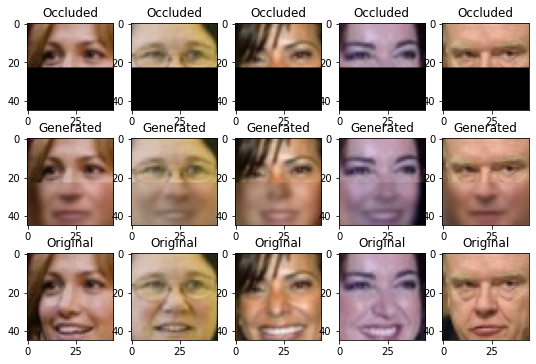

In [35]:

plt.figure(figsize=(9,6))
for i in range(5):
  oenc_op2 = occ_deep_model0_64.layers[1].predict(occXval[i][None])[0]
  odec_op2 = occ_deep_model0_64.layers[2].predict(oenc_op2[None])[0]
  retrieve_first_half(odec_op2,occXval[i])
  plt.subplot(3,5,i+1)
  plt.title("Occluded")
  plt.imshow(np.clip(occXval[i],0,1))
  plt.subplot(3,5,i+6)
  plt.title("Generated")
  plt.imshow(np.clip(odec_op2,0,1))
  plt.subplot(3,5,i+11)
  plt.title("Original")
  plt.imshow(np.clip(imgXval[i],0,1))
plt.show()

# MODEL 3

In [ ]:
def deep_cnn_model2(img_shape, latent_dim):
    H, W, C = img_shape

    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.layers.InputLayer(img_shape))
    encoder.add(tf.keras.layers.Conv2D(32, input_shape=img_shape, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    encoder.add(tf.keras.layers.Conv2D(64, input_shape=img_shape[1:], kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    encoder.add(
        tf.keras.layers.Conv2D(128, input_shape=img_shape[1:], kernel_size=(3, 3), activation='relu', padding='same'))

    encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(tf.keras.layers.Flatten())
    encoder.add(tf.keras.layers.Dense(latent_dim))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(L.InputLayer((latent_dim,)))
    decoder.add(L.Dense(np.prod(img_shape)))
    decoder.add(L.Reshape(img_shape))

    decoder.add(L.Conv2DTranspose(64, input_shape=img_shape, kernel_size=(3, 3), activation='relu', padding='same'))

    decoder.add(L.Conv2DTranspose(32, input_shape=img_shape, kernel_size=(3, 3), activation='relu', padding='same'))

    decoder.add(L.Conv2DTranspose(3, input_shape=img_shape, kernel_size=(3, 3), activation=None, padding='same'))

    return encoder, decoder

In [ ]:
del deep_model2_32,cnn_encoder2_32,cnn_decoder2_32

In [ ]:
cnn_encoder2_32, cnn_decoder2_32 = deep_cnn_model2(IMG_SHAPE, latent_dim=16)

inp2_32 = tf.keras.layers.Input(IMG_SHAPE)
enc_op2_32 = cnn_encoder2_32(inp2_32)
dec_op2_32 = cnn_decoder2_32(enc_op2_32)

deep_model2_32 = tf.keras.models.Model(inp2_32,dec_op2_32)
deep_model2_32.compile(optimizer="adam", loss='mse')
hist2_32 = deep_model2_32.fit(x=imgXtrain,y=imgXtrain, epochs=25,validation_data=(imgXval,imgXval))


Epoch 1/25
329/329 [==============================] - 5s 13ms/step - loss: 0.0263 - val_loss: 0.0128
Epoch 2/25
329/329 [==============================] - 4s 12ms/step - loss: 0.0105 - val_loss: 0.0098
Epoch 3/25
329/329 [==============================] - 4s 12ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 4/25
329/329 [==============================] - 4s 12ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 5/25
329/329 [==============================] - 4s 12ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 6/25
329/329 [==============================] - 4s 12ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 7/25
329/329 [==============================] - 4s 12ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 8/25
329/329 [==============================] - 4s 12ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 9/25
329/329 [==============================] - 4s 12ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 10/25
329/329 [==============================] - 4s 12ms/step - loss: 0.0069 - val_lo

In [ ]:
deep_model2_32.evaluate(imgXval,imgXval)

83/83 [==============================] - 0s 6ms/step - loss: 0.0068


0.00680640060454607

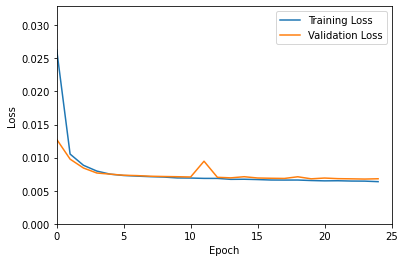

In [ ]:

epochs_range = range(25)
val_loss = hist2_32.history['val_loss']
tr_loss = hist2_32.history['loss']
plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, (1+0.25)*max(max(tr_loss),max(val_loss))])
plt.xlim([0, 25])

plt.legend(loc='upper right')

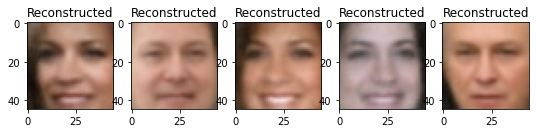

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  enc_op2 = cnn_encoder2_32.predict(imgXval[i][None])[0]
  dec_op2 = cnn_decoder2_32.predict(enc_op2[None])[0]
  
  plt.subplot(1,5,i+1)
  plt.title("Reconstructed")
  plt.imshow(np.clip(dec_op2,0,1))
plt.show()

## Improve Latent dim

In [ ]:
del deep_model_64,cnn_decoder_64,cnn_encoder_64

In [ ]:
cnn_encoder_64, cnn_decoder_64 = deep_cnn_model(IMG_SHAPE, latent_dim=64)

inp_64 = tf.keras.layers.Input(IMG_SHAPE)
enc_op_64 = cnn_encoder_64(inp_64)
dec_op_64 = cnn_decoder_64(enc_op_64)

deep_model_64 = tf.keras.models.Model(inp_64,dec_op_64)
deep_model_64.compile(optimizer="adam", loss='mse')
hist_64 = deep_model_64.fit(x=imgXtrain,y=imgXtrain, epochs=15,validation_data=(imgXval,imgXval))


Epoch 1/15
329/329 [==============================] - 8s 22ms/step - loss: 0.0219 - val_loss: 0.0094
Epoch 2/15
329/329 [==============================] - 7s 21ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 3/15
329/329 [==============================] - 7s 21ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 4/15
329/329 [==============================] - 7s 21ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 5/15
329/329 [==============================] - 7s 21ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 6/15
329/329 [==============================] - 7s 22ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 7/15
329/329 [==============================] - 7s 21ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 8/15
329/329 [==============================] - 7s 21ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 9/15
329/329 [==============================] - 7s 21ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 10/15
329/329 [==============================] - 7s 21ms/step - loss: 0.0039 - val_lo

In [ ]:
deep_model_64.evaluate(imgXval,imgXval)

83/83 [==============================] - 1s 8ms/step - loss: 0.0038


0.0037762592546641827

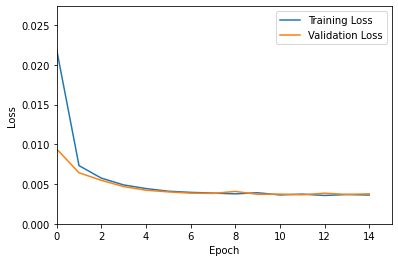

In [ ]:

epochs_range = range(15)
val_loss = hist_64.history['val_loss']
tr_loss = hist_64.history['loss']
plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, (1+0.25)*max(max(tr_loss),max(val_loss))])
plt.xlim([0, 15])

plt.legend(loc='upper right')

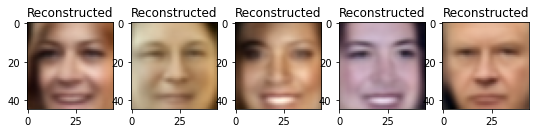

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  enc_op3 = cnn_encoder_64.predict(imgXval[i][None])[0]
  dec_op3 = cnn_decoder_64.predict(enc_op3[None])[0]
  
  plt.subplot(1,5,i+1)
  plt.title("Reconstructed")
  plt.imshow(np.clip(dec_op3,0,1))
plt.show()